# Chapter 5 - Support Vector Machines

## 1. Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 2. Linear SVM Classification

SVM classifier attempts to fit the widest street possible between classes
- This is called **large margin classification**

**Hard margin classification** means that all instances must be off the street and on the correct side of the street
- However, sometimes this results in impossible to fit SVM or outliers creating narrow streets

**Soft margin classification** is a more flexible model that finds a good balance between keeping the street as large as possible and limiting *margin violations*
- *margin violations* are instances that end up in the middle of the street or on the wrong side of the street

**C hyperparameter**
- this hyperparameter allows for more violations with a smaller value, but is stricter and smaller with a higher value. Higher values may overfit

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [3]:
iris = datasets.load_iris()
X = iris['data'][:, (2, 3)] # petal length, petal width
y = (iris['target'] == 2).astype(np.float64) # Iris virginica

In [4]:
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42)),
])

In [5]:
svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [6]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

## 3. Nonlinear SVM Classification

Sometimes linear SVMs don't work because the dataset isn't close to being linearly separable

Adding nonlinear features such as polynomial features can create a linearly separable dataset

In [7]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

In [8]:
X, y = make_moons(n_samples=100, noise=0.15)
poly_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=10, loss='hinge'))
])

In [9]:
poly_svm_clf.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

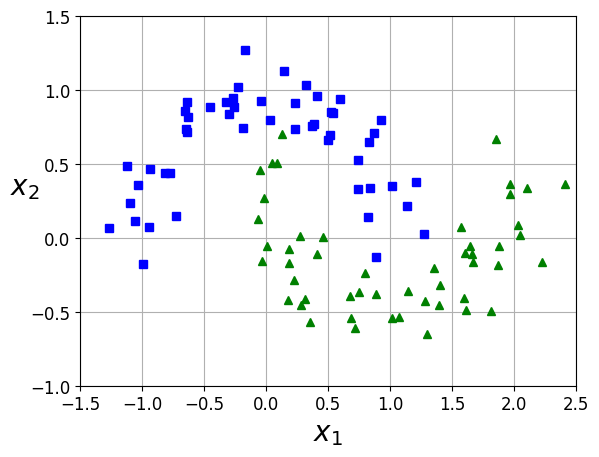

In [10]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

Saving figure moons_polynomial_svc_plot


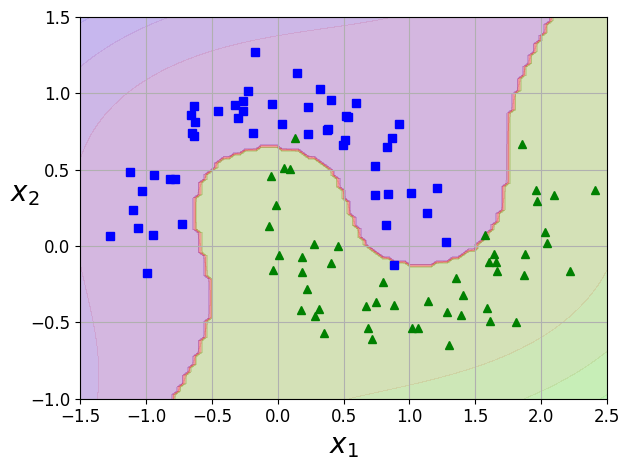

In [11]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(poly_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

### 2.1 Polynomial Kernel

At low polynomial degree, the above method cannot deal with very complex datasets

With high polynomial degree, too many features are created and the model is very slow

**Kernel Trick**
- makes it possible to get the same result as if you had added a lot of polynomial features, without adding all of those features

In [12]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

## 2.2 Gaussian RBF Kernel

In [13]:
rbf_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
])

rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

Saving figure moons_rbf_svc_plot


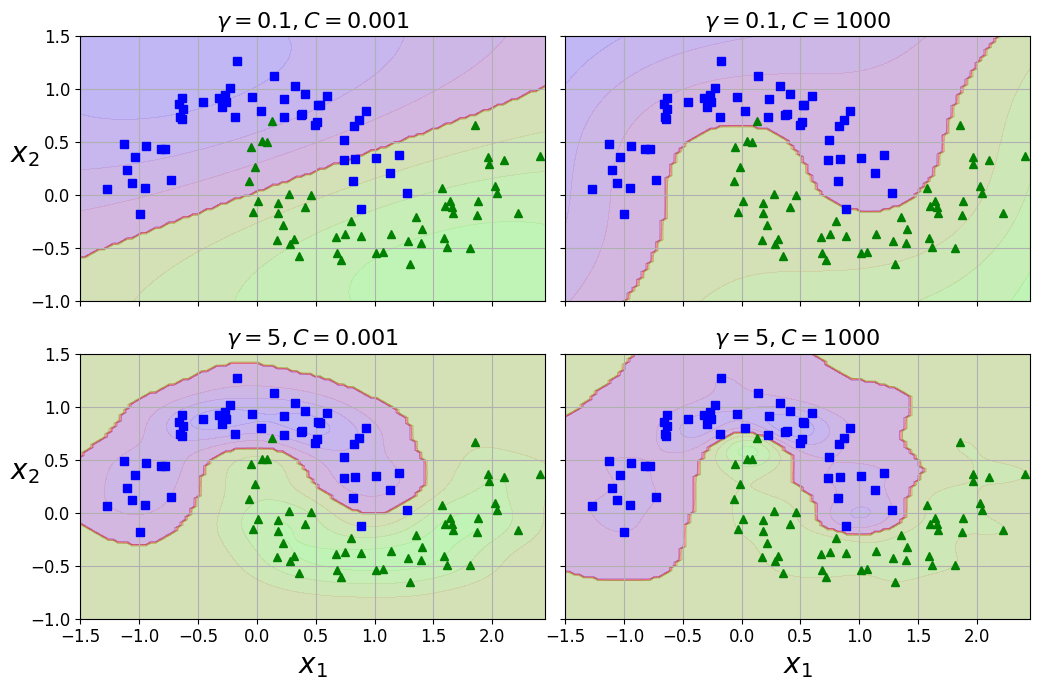

In [14]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

## 3. SVM Regression

In [15]:
np.random.seed(42)
m = 50
X = 2 * np.random.randn(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [16]:
from sklearn.svm import LinearSVR

In [17]:
svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

In [18]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X,y)
svm_reg2.fit(X,y)

LinearSVR(epsilon=0.5, random_state=42)

In [19]:
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

In [20]:
svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

In [21]:
eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

In [22]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

Saving figure svm_regression_plot


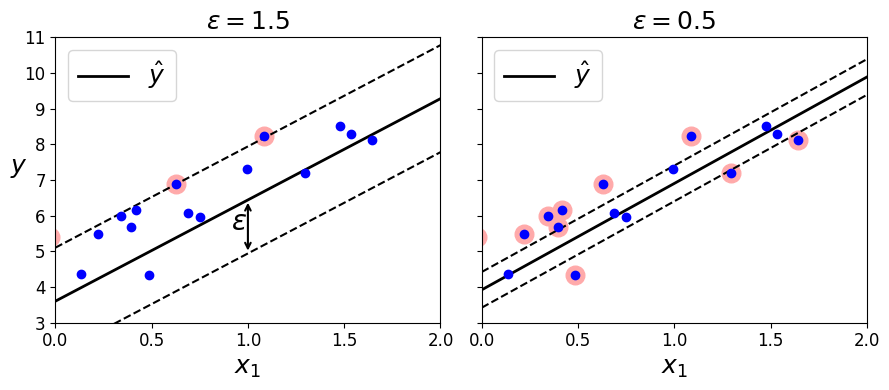

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r'$\epsilon = {}$'.format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r'$y$', fontsize=18, rotation=0)
plt.annotate(
    '', xy=(eps_x1, eps_y_pred), xycoords='data',
    xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
    textcoords='data', arrowprops={'arrowstyle':'<->', 'linewidth': 1.5}
)
plt.text(0.91, 5.6, r'$\epsilon$', fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r'$\epsilon = {}$'.format(svm_reg2.epsilon), fontsize=18)
save_fig('svm_regression_plot')
plt.show()

1. What is the fundamental idea behind Support Vector Machines?

Finding the model with the appropriate decision boundary that cleanly separates and stays as far away from the closest training instances as possible

2. What is a support vector?

An instance that marks the edge of the "street" aka the decision boundary between the classes

3. Why is it important to scale the inputs when using SVMs?

SVMs are very sensitive to feature scales and it will alter the decision boundary

4. Can an SVM classifier output a confidence score when it classifies an instance? What about a probability?

No to both

5. Should you train on the primal or the dual form of th SVM problem to train a model on a training set with millions of instances and hundreds of features?

dual form aka polynomial

6. Say you've trained an SVM classifier with an RBF kernel, but it seems to underfit the training set. Should you increase or decrease Y (gamma)? What about C?

Increase gamma and C